# Proyecto Final Analítica computacional para la toma de decisiones

Departamento de Ingeniería Industrial

Universidad de los Andes

Tecnológico de Monterrey
## Etapa 4b - Modelos predictivos Andes - Clasificación
1. Carga de librerías y configuración inicial
Importamos las librerías necesarias.

Configuramos la semilla para que los experimentos sean reproducibles.

In [2]:
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras

# --------------------------------------------------------------
# Fijamos semillas para reproducibilidad básica
# --------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


2. Carga del conjunto de datos limpio
Cargamos el dataset limpio (listings_model_no_outliers.csv).

Verificamos las dimensiones y las primeras filas del dataframe.

In [3]:
# Cargar el dataset limpio sin outliers
df = pd.read_csv("C:/Users/Miguel A Ortiz/Documents/Analítica/Proyecto/2 SEGUNDA SUBIDA/listings_model_no_outliers.csv")

# Verificación inicial de las dimensiones
print(f"Dimensiones del dataset limpio: {df.shape}")
df.head()


Dimensiones del dataset limpio: (40550, 147)


,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,...,property_type_Shepherd’s hut,property_type_Tent,property_type_Tiny home,property_type_Tower,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_No,host_is_superhost_Yes,instant_bookable_Yes
0,13913,51.56861,-0.11270,1,1.0,1.0,1.0,70.0,1,29,...,False,False,False,False,False,True,False,False,True,False
1,15400,51.48780,-0.16813,2,1.0,1.0,1.0,149.0,4,30,...,False,False,False,False,False,False,False,True,False,False
2,24328,51.47072,-0.16266,2,1.0,1.0,2.0,135.0,7,1125,...,False,False,False,False,False,False,False,True,False,False
3,36274,51.52322,-0.06979,4,1.0,1.0,0.0,210.0,5,1125,...,False,False,False,False,False,False,False,True,False,True
4,38995,51.47860,-0.06114,2,1.0,1.0,1.0,49.0,1,8,...,False,False,False,False,False,True,False,False,True,False


3. Preparación de datos para clasificación
Creamos las variables predictoras X y el objetivo y para la clasificación.

Imputamos los valores nulos en las características numéricas usando la mediana.

Realizamos un split de los datos en entrenamiento y prueba (train/test).

Normalizamos los datos utilizando StandardScaler.

In [4]:
print(df.columns)


Index(['id', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       ...
       'property_type_Shepherd’s hut', 'property_type_Tent',
       'property_type_Tiny home', 'property_type_Tower',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_No',
       'host_is_superhost_Yes', 'instant_bookable_Yes'],
      dtype='object', length=147)


In [5]:
# Variables predictoras (X) y objetivo (y)
X = df.drop(columns=["price", "host_is_superhost_No", "host_is_superhost_Yes"])  # Eliminamos las columnas one-hot de 'host_is_superhost'
y = df["host_is_superhost_Yes"]  # Usamos 'host_is_superhost_Yes' como la variable objetivo de clasificación

# Imputar valores nulos en las características numéricas (usando la mediana)
X = X.fillna(X.median())

# División de los datos en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos preparados para clasificación.")


Datos preparados para clasificación.


4. Creación del modelo de clasificación (red neuronal)
Creamos una función para construir un modelo de red neuronal para clasificación binaria (superhost o no superhost).

Se utiliza sigmoid en la capa de salida para obtener probabilidades de clase.

binary_crossentropy se usa como función de pérdida, adecuada para clasificación binaria.

In [6]:
# Función para construir el modelo de clasificación con redes neuronales
def build_classification_model(input_dim, n_layers=2, n_units=64, learning_rate=1e-3):
    model = keras.Sequential(name="nn_classification_superhost")
    
    # Capa de entrada
    model.add(keras.layers.Input(shape=(input_dim,), name="input"))
    
    # Capas ocultas (activación ReLU)
    for i in range(n_layers):
        model.add(
            keras.layers.Dense(
                n_units,
                activation="relu",
                name=f"dense_hidden_{i+1}"
            )
        )
    
    # Capa de salida (activación sigmoide para clasificación binaria)
    model.add(
        keras.layers.Dense(
            1,
            activation="sigmoid",
            name="output_superhost"
        )
    )

    # Compilamos el modelo
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",  # Para clasificación binaria
        metrics=["accuracy"]
    )

    return model


5. Entrenamiento del modelo
Creamos el modelo con las dimensiones de entrada del conjunto de datos.

Entrenamos el modelo con los datos de entrenamiento, validando con los datos de prueba.

In [7]:
# Construir el modelo con la arquitectura deseada
input_dim = X_train_scaled.shape[1]  # Número de características
model_cls = build_classification_model(input_dim=input_dim)

# Entrenar el modelo
history = model_cls.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8674 - loss: 0.3449 - val_accuracy: 0.8703 - val_loss: 0.3190
Epoch 2/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8770 - loss: 0.3051 - val_accuracy: 0.8727 - val_loss: 0.3136
Epoch 3/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8814 - loss: 0.2949 - val_accuracy: 0.8741 - val_loss: 0.3102
Epoch 4/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8830 - loss: 0.2877 - val_accuracy: 0.8759 - val_loss: 0.3075
Epoch 5/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8855 - loss: 0.2822 - val_accuracy: 0.8764 - val_loss: 0.3060
Epoch 6/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8873 - loss: 0.2777 - val_accuracy: 0.8768 - val_loss: 0.3050
Epoch 7/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8894 - loss: 0.2736 - val_accuracy: 0.8774 - val_loss: 0.3046
Epoch 8/50
444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8908 - loss: 0.2699 - val_accuracy: 0.

6. Evaluación del modelo
Predicciones: Obtenemos las predicciones del modelo (probabilidades) y las convertimos a clases binarias (0 o 1) utilizando el umbral de 0.5.

Evaluación: Calculamos la precisión y mostramos el reporte de clasificación (con precision, recall y f1-score).

Matriz de confusión: Visualizamos el desempeño del modelo utilizando una matriz de confusión.

381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precisión del modelo de clasificación: 0.8718

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.90      0.96      0.93     10455
        True       0.58      0.33      0.42      1710

    accuracy                           0.87     12165
   macro avg       0.74      0.64      0.67     12165
weighted avg       0.85      0.87      0.86     12165



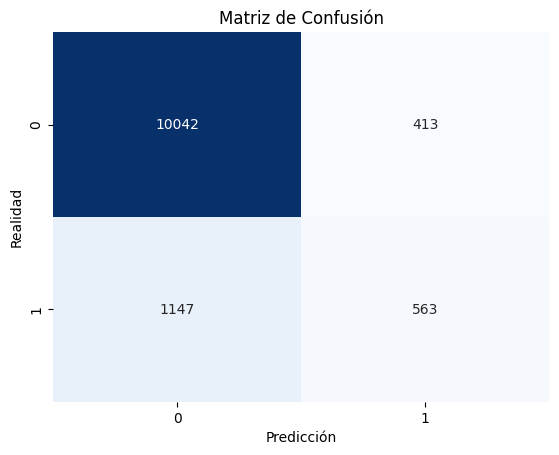

In [8]:
# Evaluación del modelo en el conjunto de test
y_pred_cls = (model_cls.predict(X_test_scaled) > 0.5).astype("int32")

# Métricas de desempeño
accuracy = accuracy_score(y_test, y_pred_cls)
print(f"Precisión del modelo de clasificación: {accuracy:.4f}")

# Reporte de clasificación (precision, recall, f1-score)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_cls))

# Matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred_cls)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()


7. Resumen final del modelo
Se imprime un resumen completo del modelo para ver su arquitectura y detalles de las capas.

In [9]:
# Resumen final del modelo entrenado
print("\nResumen final del modelo de clasificación (red neuronal):")
model_cls.summary()



Resumen final del modelo de clasificación (red neuronal):


Model: "nn_classification_superhost"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_hidden_1 (Dense)          │ (None, 64)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_superhost (Dense)        │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,517 (158.27 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,012 (105.52 KB)